# NLP Case Study - Automatic Ticket Classification

## Problem Statement
We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

- Credit card / Prepaid card

- Bank account services

- Theft/Dispute reporting

- Mortgages/loans

- Others

With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

Pipelines that needs to be performed:
We need to perform the following eight major tasks to complete the assignment:

1.Data loading

2.Text preprocessing

3.Exploratory data analysis (EDA)

4.Feature extraction

5.Topic modelling

6.Model building using supervised learning

7.Model training and evaluation

8.Model inference

#### Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd

import re,nltk,spacy,string
import en_core_web_sm
nlp=en_core_web_sm.load()
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from pprint import pprint   
from sklearn.decomposition import NMF

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\uttamkumar81\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uttamkumar81\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uttamkumar81\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uttamkumar81\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Remove warnings

import warnings
warnings.filterwarnings('ignore')

## Data Reading/Data Understanding

The data is in JSON format and we need to convert it to the dataframe

In [3]:
# Opening the JSON file
f=r"C:\Users\HP\Downloads\complaints-2021-05-14_08_16.json"


with open(f,'r') as file:
    data=json.load(file)

df=pd.json_normalize(data)

In [4]:
# column display limit

pd.set_option('display.max_columns', None)

# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data Cleaning

In [5]:
df.shape

(78313, 22)

In [6]:
#print the column names

list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
new_columns=zip(list(df.columns),[(x.replace("_","")).replace("source.","") for x in list(df.columns)])

In [8]:
#Assign new column names
df=df.rename(columns=dict(new_columns))
df=df.rename(columns={"complaintwhathappened":"complaints","complaintid":"complaint_id","datereceived":"date_received","consumerdisputed":"consumer_disputed",
                     "companyresponse":"company_response","submittedvia":"submitted_via","datesenttocompany":"date_sent_to_company",
                     "companypublicresponse":"company_public_response","subproduct":"sub_product","subissue":"sub_issue",
                      "consumerconsentprovided":"consumer_consent_provided"})

# check changes column names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaints',
       'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zipcode                    71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [10]:
# check for null values

df1=(df['complaints'] == '').sum()
df1

57241

In [11]:
## Replace empty strings with NaN in the 'complaints' column 
df['complaints']=df['complaints'].mask(df['complaints']=="",pd.NA)

## dropping the rows with NaN
df=df[~(df['complaints'].isnull())].reset_index()
df.shape

(21072, 23)

In [12]:
21072/78313 * 100

26.90741000855541

#### We have around 27% of the original data available for further analysis

## Data Preprocessing

##### Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:
    
-  Make the text lowercase
-  Remove text in square brackets
-  Remove punctuation
-  Remove words containing numbers

Once you have done these cleaning operations you need to perform the following:

-  Lemmatize the texts
-  Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [13]:
#Defining a function to clean the text - convert the text to lower case, remove text in square brackets, remove punctuation, remove words containing numbers

def clean(complaint):
    complaint= complaint.lower()
    complaint=re.sub(r"\[\s*w*\s*\]","",complaint)
    complaint=re.sub(r"\S\d\S","",complaint)
    complaint=complaint.translate(str.maketrans('', '', string.punctuation))
    return complaint

cleaned_complaints=df['complaints'].apply(clean)

In [14]:
#define a function to lemmatize the text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokenized_words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenized_words]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

lemmatized_complaints = cleaned_complaints.apply(lemmatize_text)

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean=pd.DataFrame({'complaints':df['complaints'],'Lemmatized_complaints':lemmatized_complaints})

In [16]:
pd.set_option('display.max_colwidth', None)

df_clean.head()

,complaints,Lemmatized_complaints
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on xxxx while trying to book a xxxx xxxx ticket i came across an offer for 0 to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted chase b

In [17]:
#Write your function to extract the POS tags 

def get_pos_tag(text):
    noun_words=[]
    doc=nlp(text)
    for tok in doc:
        if(tok.tag_=="NN"):
            noun_words.append(tok.lemma_)
    noun_words_str=" ".join(noun_words)
    return noun_words_str

df_clean["complaint_POS_removed"]=df_clean.apply(lambda x:get_pos_tag(x['Lemmatized_complaints']),axis=1)

In [18]:
#df_clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",on xxxx while tr

## Exploratory data analysis 


- Visualise the data according to the 'Complaint' character length
- Using a word cloud find the top 40 words by frequency among all the articles after processing the text
- Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

**Visualise the data according to the 'Complaint' character length**

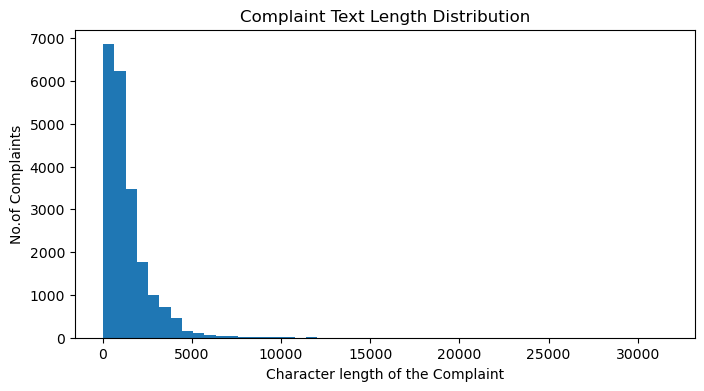

In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(8,4))
plot=df['complaints'].str.len()
plt.hist(plot,bins=50)
plt.xlabel("Character length of the Complaint")
plt.ylabel("No.of Complaints")
plt.title('Complaint Text Length Distribution')

plt.show()

Inference
- Most of the the complaints have the length in the range of 50-200 words
- Very few compliants are of length more than 2000 words

**Find the top 40 words by frequency**

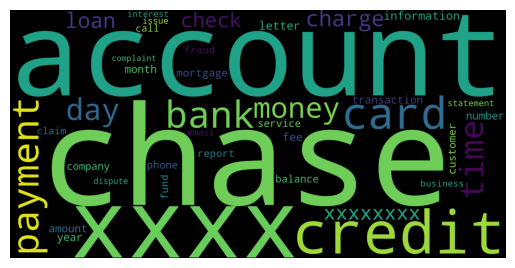

In [20]:
# To find the top 40 words by frequency among all the articles after processing the text

word_cloud=WordCloud(collocations = False, width = 2000, height = 1000,max_words=40).generate(" ".join(df_clean['complaint_POS_removed']))
fig=plt.figure(1)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


- Words like card,account,chase,credit,payment are high frequent in the text.
- The word chase has the highest frequency, as it is the company name ,hence mostly used.
- All the personal details of the customers are masked with XXXX and hence carry no information

In [21]:
##Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [22]:
#All personal details of customers have been marked as xx... Such masks can be removed as they don't carry any information

df_clean['Complaint_clean']=df_clean['Complaint_clean'].str.replace('xxxx',"")

In [23]:
df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent,card 18 agent anniversary date agent information order account anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase repres

**Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [24]:
# Defining functions to return thr top 'n' words from the text corpus for given 'n_gram_range'

def get_top_n_gram(corpus,n_gram_range,n=None):
    vec=CountVectorizer(ngram_range=(n_gram_range,n_gram_range),stop_words='english').fit(corpus)
    bag_of_word=vec.transform(corpus)
    sum_words=bag_of_word.sum(axis=0)
    word_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()]
    word_freq=sorted(word_freq,key=lambda x:x[1],reverse=True)
    return word_freq[:n]

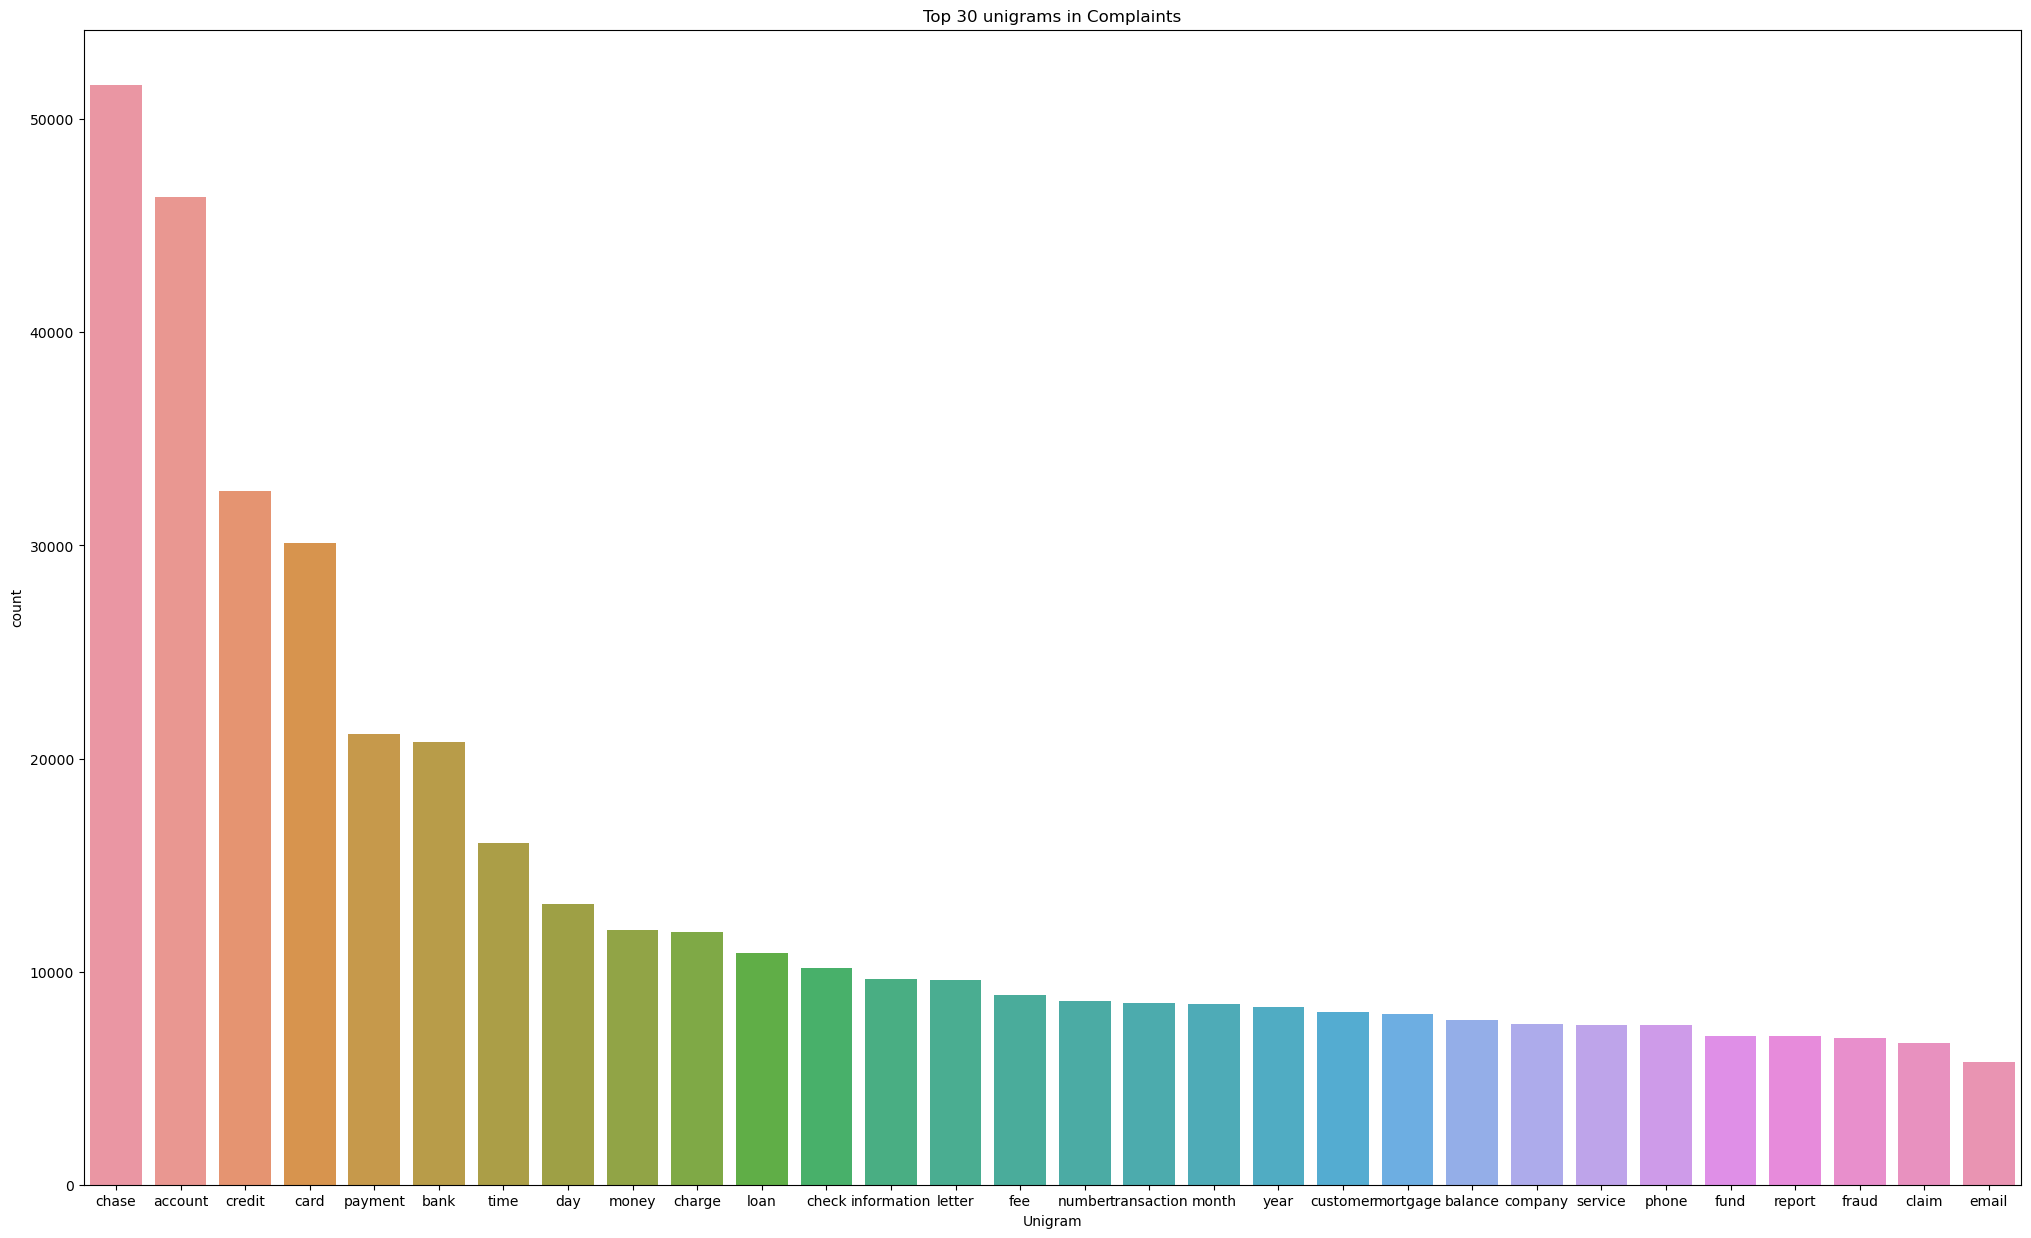

Top 10 words in the unigram frequency


,Unigram,count
0,chase,51622
1,account,46346
2,credit,32567
3,card,30109
4,payment,21171
5,bank,20780
6,time,16038
7,day,13156
8,money,11954
9,charge,11868


In [25]:
## Visulaization for for unigram words

unigram= get_top_n_gram(df_clean['Complaint_clean'],1,30)
df_1=pd.DataFrame(unigram,columns=["Unigram","count"])

plt.figure(figsize=[25,15])
figure=sns.barplot(x=df_1["Unigram"],y=df_1['count'])
plt.title("Top 30 unigrams in Complaints")
plt.show()

# Top 10 words in the unigram frequency
print("Top 10 words in the unigram frequency")
df_1.head(10)

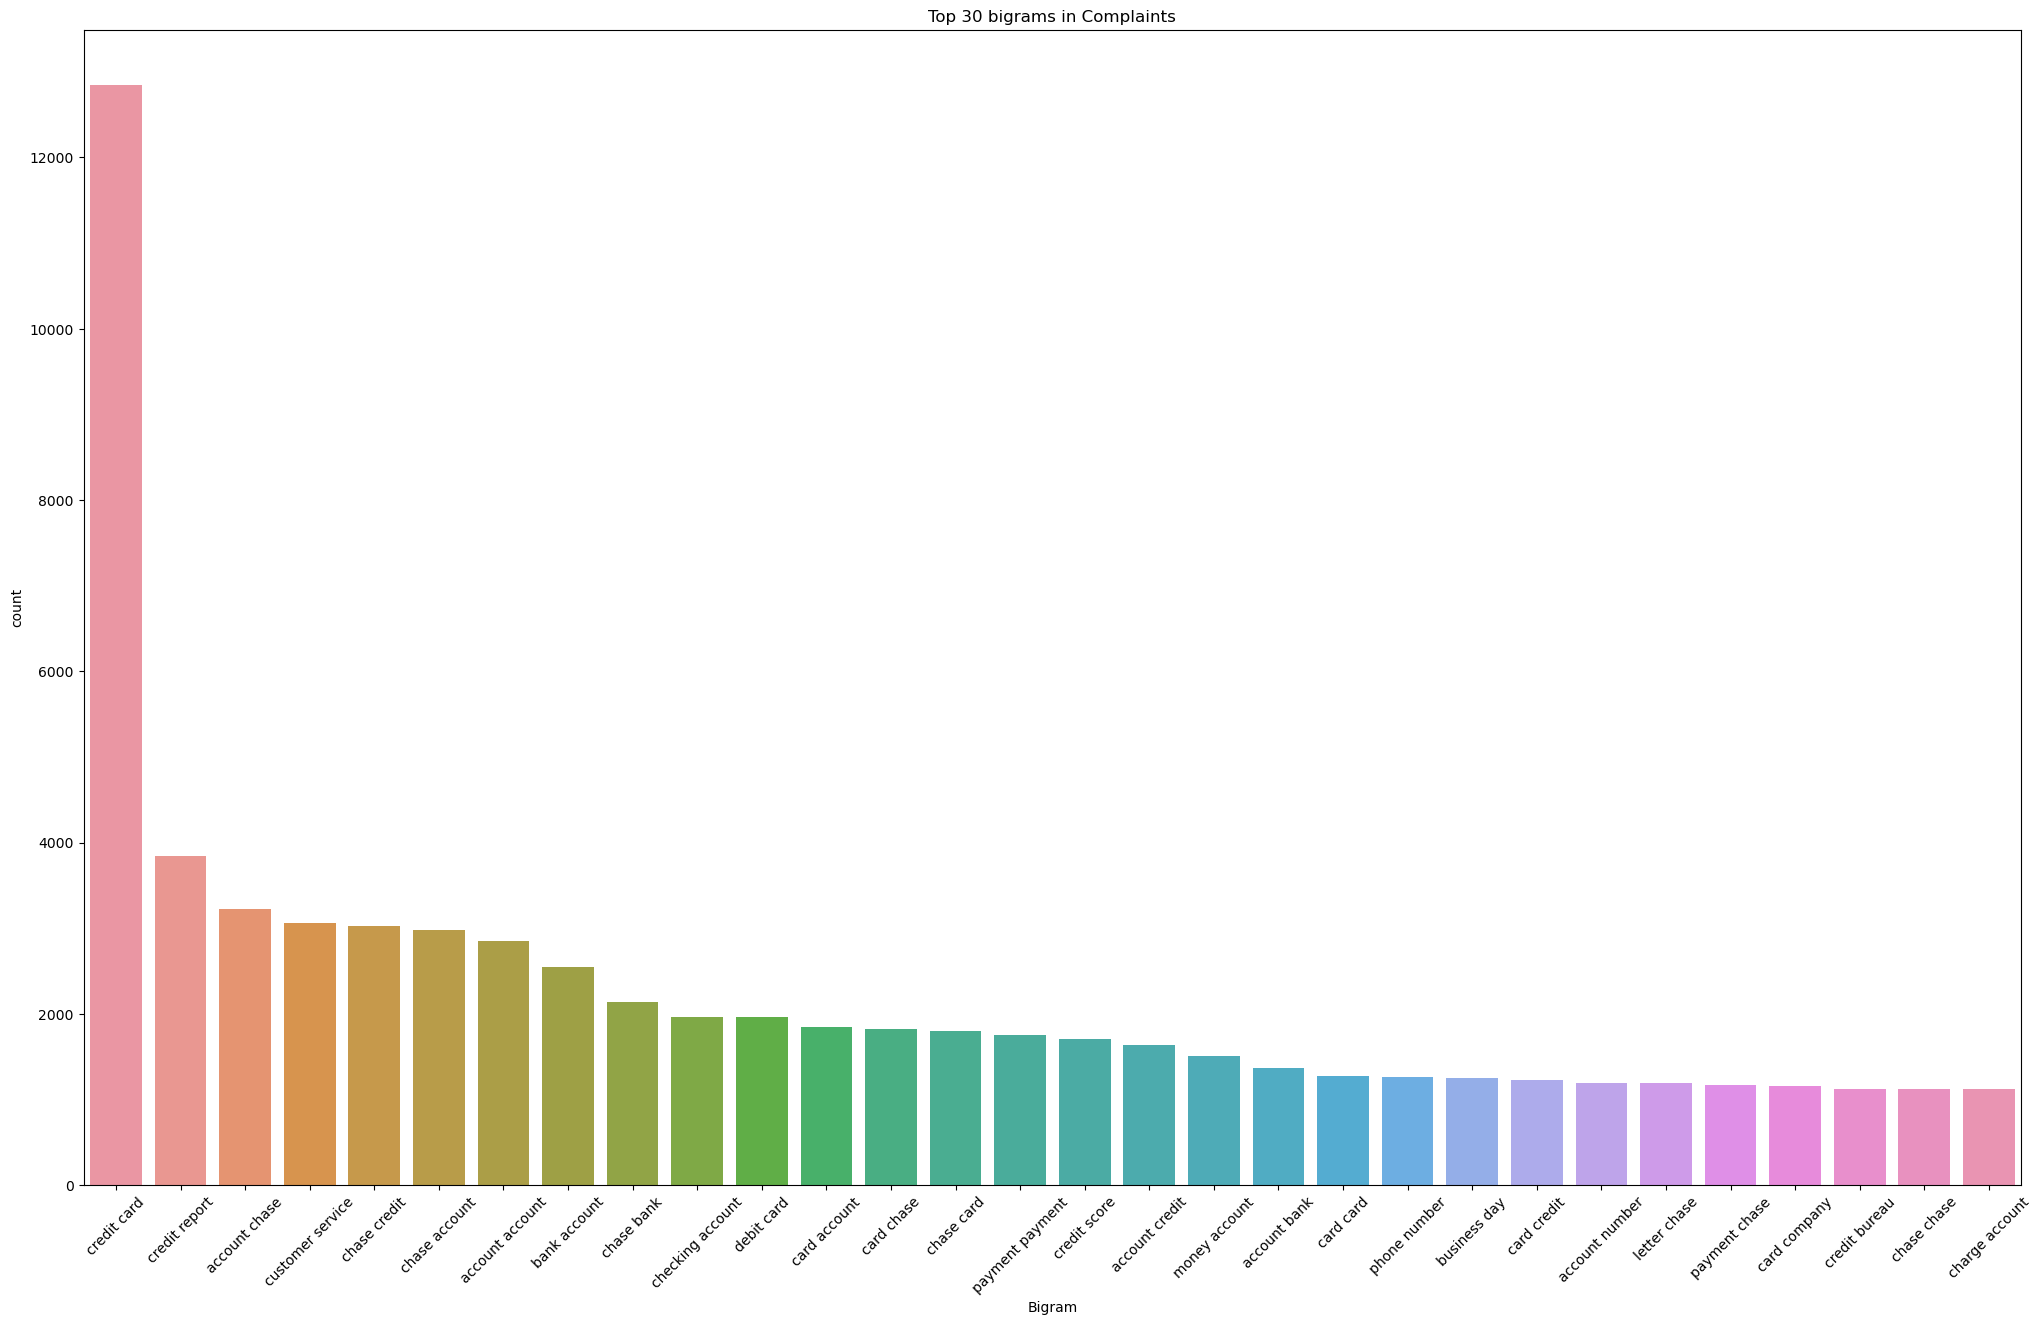

Top 10 words in the bigram frequency


,Bigram,count
0,credit card,12846
1,credit report,3848
2,account chase,3221
3,customer service,3060
4,chase credit,3029
5,chase account,2974
6,account account,2852
7,bank account,2541
8,chase bank,2138
9,checking account,1967


In [26]:
## Visulaization for for bigram words


bigram= get_top_n_gram(df_clean['Complaint_clean'],2,30)
df_2=pd.DataFrame(bigram,columns=["Bigram","count"])

plt.figure(figsize=[25,15])
figure=sns.barplot(x=df_2["Bigram"],y=df_2['count'])
plt.xticks(rotation=45)
plt.title("Top 30 bigrams in Complaints")
plt.show()

# Top 10 words in the bigram frequency
print("Top 10 words in the bigram frequency")
df_2.head(10)

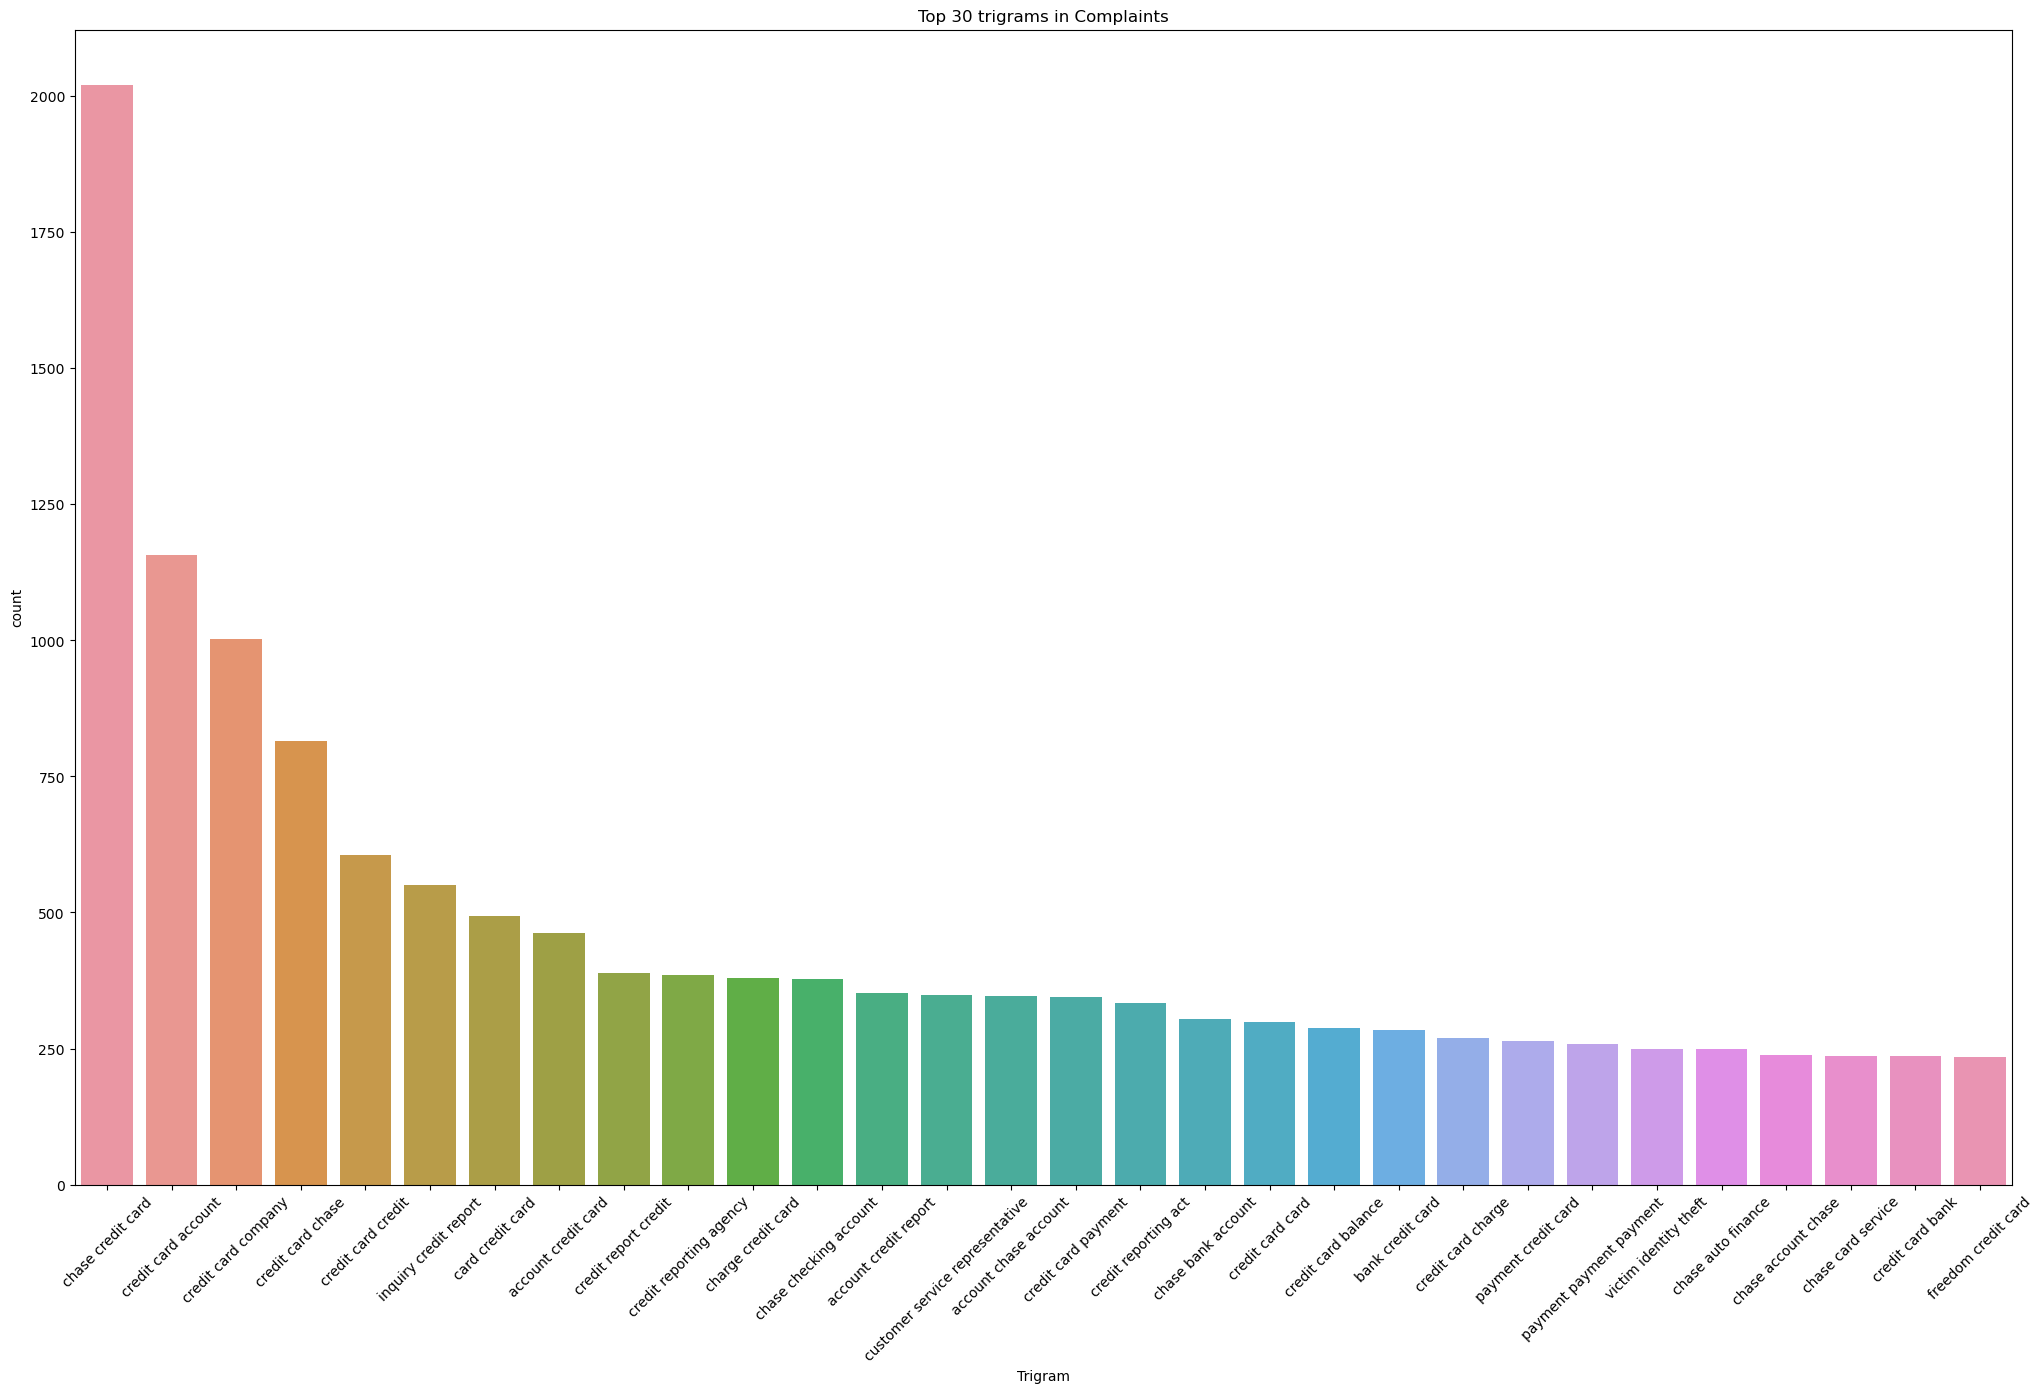

Top 10 words in the trigram frequency


,Trigram,count
0,chase credit card,2021
1,credit card account,1157
2,credit card company,1002
3,credit card chase,815
4,credit card credit,606
5,inquiry credit report,550
6,card credit card,493
7,account credit card,463
8,credit report credit,389
9,credit reporting agency,385


In [27]:
## Visulaization for for trigram words


trigram= get_top_n_gram(df_clean['Complaint_clean'],3,30)
df_3=pd.DataFrame(trigram,columns=["Trigram","count"])

plt.figure(figsize=[25,15])
figure=sns.barplot(x=df_3["Trigram"],y=df_3['count'])
plt.xticks(rotation=45)
plt.title("Top 30 trigrams in Complaints")
plt.show()

# Top 10 words in the trigram frequency
print("Top 10 words in the trigram frequency")
df_3.head(10)

In [28]:
df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent,card 18 agent anniversary date agent information order account anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase repres

## Feature Extraction

Convert the raw texts to a matrix of TF-IDF features

In [29]:
# Initialise the TfidfVectorizer 

tfidf=TfidfVectorizer(stop_words='english',min_df=2,max_df=0.95)

**Create a document term matrix using fit_transform**

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0.

In [30]:
## Code to create the Document Term Matrix by transforming the 'Complaint_clean' column present in df_clean

dtm=tfidf.fit_transform(df_clean['Complaint_clean'])
features=tfidf.get_feature_names_out()

In [31]:
len(features)

6124

In [32]:
#Create a dataframe to display Document Term Matrix

tfidf_df=pd.DataFrame(dtm.toarray(),columns=features)
tfidf_df.head()

08  0mo   0n   12   14   15   16   17        18   19  1day  1hr  1rs  1s2  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.206718  0.0   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   0.0  0.0  0.0  0.0   

   1st   20   21  2day  2nd  2xs   3d  3day  3rd  4th   6i  7day   aa  aarp  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0   0.0   

   abandonment  abatement  abbreviation  abide  ability  absence  absurdity  \
0          0.0        0.0           0.0    0.0      0.0      0.0        0.0   
1          0.0        0.0           0.0    0.0      0.0      0.0        0.0   
2          0.0        0.0           0.0    0.0      0.0      0.0        0.0   
3          0.0        0.0           0.0    0.0      0.0      0.0        0.0   
4          0.0        0.0           0.0    0.0      0.0      0.0        0.0   

   abundance  abuse  abuser   ac  acc  acccount  acceleration  accent  accept  \
0        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
1        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
2        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
3        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   
4        0.0    0.0     0.0  0.0  0.0       0.0           0.0     0.0     0.0   

   acceptance  access  accessibility  accessory  accident  accommodation  \
0         0.0     0.0            0.0        0.0       0.0            0.0   
1         0.0     0.0            0.0        0.0       0.0            0.0   
2         0.0     0.0            0.0        0.0       0.0            0.0   
3         0.0     0.0            0.0        0.0       0.0            0.0   
4         0.0     0.0            0.0        0.0       0.0            0.0   

   accomplice  accont  accord  accordance  accou  accouint  accoun   account  \
0         0.0     0.0     0.0         0.0    0.0       0.0     0.0  0.086208   
1         0.0     0.0     0.0         0.0    0.0       0.0     0.0  0.068757   
2         0.0     0.0     0.0         0.0    0.0       0.0     0.0  0.000000   
3         0.0     0.0     0.0         0.0    0.0       0.0     0.0  0.126205   
4         0.0     0.0     0.0         0.0    0.0       0.0     0.0  0.137439   

   accountability  accountant  accountbalance  accountchase  accountholder  \
0             0.0         0.0             0.0           0.0            0.0   
1             0.0         0.0             0.0           0.0            0.0   
2             0.0         0.0             0.0           0.0            0.0   
3             0.0         0.0             0.0           0.0            0.0   
4             0.0         0.0             0.0           0.0            0.0   

   accounti  accounting  accountit  accountlevel  accountone  accountplease  \
0       0.0         0.0        0.0           0.0         0.0            0.0   
1       0.0         0.0        0.0           0.0         0.0            0.0   
2       0.0         0.0        0.0           0.0         0.0            0.0   
3       0.0         0.0        0.0           0.0         0.0            0.0   
4       0.0         0.0        0.0           0.0         0.0            0.0   

   accountschasecom  accountshe  accout  accrual  acct  accumulation  accunt  \
0               0.0         0.0     0.0      0.0   0.0           0.0     0.0   
1               0.0         0.0     0.

In [33]:
tfidf_df.shape

(21072, 6124)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we are performing the following:

- Find the best number of clusters
- Apply the best number to create word clusters
- Inspect & validate the correction of each cluster wrt the complaints
- Correct the labels if needed
- Map the clusters to topics/cluster names

## Manual Topic Modeling

In [34]:
#Load your nmf_model with the n_components 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)

In [35]:
# fit the nmf model

nmf_model.fit(dtm)
H= nmf_model.components_

In [36]:
len(tfidf.get_feature_names_out())


6124

In [37]:
#Definine a function to print Top15 words for each of the topics

def print_to_n_words(n):
    words=np.array(tfidf.get_feature_names_out())
    topic_words=pd.DataFrame(np.zeros((num_topics,n)),index=[f'Topics{i}' for i in range(num_topics)],
                            columns=[f'Word{i+1}' for i in range(n)]).astype(str)
    for i in range(num_topics):
        ix=H[i].argsort()[::-1][:n]
        topic_words.iloc[i]=words[ix]
    return topic_words

In [38]:
# The top 15 words for each of the topics

topic_words_15=print_to_n_words(15)
print("Top 15 words for each of the topics : \n\n", topic_words_15.T)

Top 15 words for each of the topics : 

             Topics0   Topics1       Topics2      Topics3      Topics4
Word1       account      card       payment      inquiry       charge
Word2         check    credit          loan       report        chase
Word3          bank     chase      mortgage       credit  transaction
Word4         money   balance         chase      company      dispute
Word5          fund   account         month  information        claim
Word6         chase       fee          home       bureau        fraud
Word7       deposit     limit  modification    reporting     merchant
Word8        branch     score          time         debt       letter
Word9           day      year          year     identity        email
Word10          fee     month          rate        score      service
Word11     checking  purchase       balance        theft  information
Word12     business     point      property      account      company
Word13       number     offer           fee      

In [39]:
# Lets understand more

topic_words_50=print_to_n_words(50)
print("Top 500 words for each of the topics : \n\n", topic_words_50.T)

Top 500 words for each of the topics : 

                Topics0         Topics1         Topics2        Topics3  \
Word1          account            card         payment        inquiry   
Word2            check          credit            loan         report   
Word3             bank           chase        mortgage         credit   
Word4            money         balance           chase        company   
Word5             fund         account           month    information   
Word6            chase             fee            home         bureau   
Word7          deposit           limit    modification      reporting   
Word8           branch           score            time           debt   
Word9              day            year            year       identity   
Word10             fee           month            rate          score   
Word11        checking        purchase         balance          theft   
Word12        business           point        property        account   
Word13   

In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

best_topic=nmf_model.transform(dtm)
print("The best topic assigned for each complaint in terms of integer values 0,1,2,3 & 4 : \n",best_topic.argmax(axis=1))

The best topic assigned for each complaint in terms of integer values 0,1,2,3 & 4 : 
 [0 1 1 ... 4 1 2]


In [41]:
#Assign the best topic to each of the complaints in Topic columns

df_clean['Topic Numbers']=best_topic.argmax(axis=1)

In [42]:
df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic Numbers
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent,card 18 agent anniversary date agent information order account anniversary date consent recording agent,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told

In [43]:
# Print the first 5 compliants for each of the Topics

top5_df=df_clean.groupby('Topic Numbers').head(5)
top5_df.sort_values('Topic Numbers')

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic Numbers
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,0
10,mishandling of this account by Chase auto and XXXX.,mishandling of this account by chase auto and xxxx,account chase auto xxxx,account chase auto,0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally. Thank you",with out notice jp morgan chase restricted my account by my debit card tuesday xxxx on thursday xxxx19 i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the 

In [44]:
# Lets check how many complaints does each topic contains

df_clean['Topic Numbers'].value_counts()

0    5203
2    5184
4    4515
1    4055
3    2115
Name: Topic Numbers, dtype: int64

**After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**
    
- Bank Account services
- Credit card or prepaid card
- Theft/Dispute Reporting
- Mortgage/Loan
- Others

In [45]:
Topic_names={0:"Bank Service",1:"Credit card or prepaid card",2:"Mortgage/Loan",3:"Others",4:"Theft/Dispute Reporting"}

#Map the topic numbers to topic names

df_clean["Topic Names"] =df_clean["Topic Numbers"].map(Topic_names)

In [46]:
df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic Numbers,Topic Names
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,0,Bank Service
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent,card 18 agent anniversary date agent information order account anniversary date consent recording agent,1,Credit card or prepaid card
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my exp

## INSPECTING AND VALIDATING EACH CLUSTER AND ITS MAPPED TOPICS :

- **Complaint** Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help. 
 
 ---- Bank Service


- **Complaint** Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.

-----Credit card or prepaid card

- **Complaint** Can you please remove inquiry	

------ Others

- **Complaint** During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and waiting, I was informed the reason for the decline as it is not " contractual ''. This reason for denial baffled me and therefore I emailed the office of XXXX XXXX Executive Director, Communications, JPMorgan Chase & Co. A representative contacted me and stated Chase will follow-up. About week later a representative of XXXX XXXX XXXX XXXX office called. The representative shared her role was help resolve the matter. The representative via conference call contacted the department handing my request. After, reviewing my information my request was still denied based on " policy changes ''. I requested an explanation and representative stated a letter will be mailed with explanation. I have received XXXX letters the reason for denial was not " policy changes ''. I would like CFPB help in exploring the denial of my payment extension request especially since I have been clear reason for denial.

------ Mortgage/Loan

- **Complaint**Chase sent me an email today with the innocuous title " Important information regarding changes to your Chase account '' ( they often use similar titles for ads and other communications ). \n\nIn it, they force me into binding arbitration ( despite that never being something I had agreed to and never being a part of any contract between me and them ). \n\nThey do include a method to opt out, but have no additional information about the consequences ( many other people I've seen who have had a similar problem are afraid that Chase will close their account if they opt out ) and, even more egregiously, despite Chase simply sending an email doing this, they require me to mail them a letter with my personal information enclosed in order to opt out. \n\nThis is clearly less secure and a massive loss of both my time and money that is clearly being used solely to dissuade people from opting out. \n\nThis is blatant malpractice by Chase.


------ Theft/Dispute Reporting

## Supervised model to predict any new complaints to the relevant Topics.

Now we need to build the model to create topics for each complaints.
Since we will be using supervised learning technique we have to convert the topic names to numbers.

In [47]:
df_clean.rename(columns={"Topic Names": "Topic"}, inplace=True)

In [48]:
topic_id={"Bank Service":0,"Credit card or prepaid card":1,"Mortgage/Loan":2,"Others":3,"Theft/Dispute Reporting":4}

# replace the topic with topic id

df_clean['Topic']=df_clean['Topic'].map(topic_id)

df_clean.head()

,complaints,Lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic Numbers,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 8 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,0,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx18 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,xxxx card xxxx18 agent anniversary date agent information order account anniversary date consent xxxx recording agent,card 18 agent anniversary date agent information order account anniversary date consent recording agent,1,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1,1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to wha

In [49]:
training_data=df_clean.drop(['Lemmatized_complaints','complaint_POS_removed','Complaint_clean'],axis=1)

In [50]:
training_data.head()

,complaints,Topic Numbers,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",1,1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",3,3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0,0


**Apply the supervised models on the training data created. In this process, you have to do the following:**

- Create the vector counts using Count Vectoriser
- Transform the word vecotr to tf-idf
- Create the train & test data using the train_test_split on the tf-idf & topics

In [51]:
#code to get count vectorizer

count_vectorizer=CountVectorizer()
complaint_vector_count=count_vectorizer.fit_transform(training_data['complaints'])

In [52]:
# transform the word vector to tf-idf

tfidf_transformer=TfidfTransformer()
complaint_tfidf_transformer=tfidf_transformer.fit_transform(complaint_vector_count)

In [53]:
# split the data into train and test

X_train,X_test,y_train,y_test=train_test_split(complaint_tfidf_transformer,training_data['Topic'],train_size=0.8,random_state=42)

In [54]:
print(f"Shape of X_train:\033[1m {X_train.shape}", '\033[0m')
print(f"Shape of y_train:\033[1m {y_train.shape}", '\033[0m')
print(f"Shape of X_test:\033[1m {X_test.shape}", '\033[0m')
print(f"Shape of y_test:\033[1m {y_test.shape}", '\033[0m')

Shape of X_train: (16857, 29725) 
Shape of y_train: (16857,) 
Shape of X_test: (4215, 29725) 
Shape of y_test: (4215,) 


In [55]:
# function to display Classification Metrics and plot confusion matrix

def eval_model(y_test, y_pred, model_name):
    # print classification report of classifier
    print(f"\033[1mCLASSIFICATION REPORT FOR {model_name}\n", '\033[0m')
    print(classification_report(y_test, y_pred, target_names=["Bank Services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"]))
    
    # plot confusion matrix of the classifier
    plt.figure(figsize=(5,4))
    plt.title(f"CONFUSION MATRIX FOR {model_name}\n")
    matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card","Mortgage/Loan", "Others", "Theft/Dispute Reporting"])
    plt.show()
    
    return

## 1. Logistic Regression

In [56]:
# Logistic Regression
model_name_1="LOGISTIC REGRESSION"
logistic_regression=LogisticRegression().fit(X_train,y_train)
predicted_lr=logistic_regression.predict(X_test)


CLASSIFICATION REPORT FOR LOGISTIC REGRESSION
 
                             precision    recall  f1-score   support

              Bank Services       0.91      0.92      0.92      1036
Credit card or prepaid card       0.92      0.90      0.91       834
                     Others       0.92      0.95      0.94      1002
    Theft/Dispute Reporting       0.93      0.84      0.88       439
              Mortgage/Loan       0.87      0.89      0.88       904

                   accuracy                           0.91      4215
                  macro avg       0.91      0.90      0.91      4215
               weighted avg       0.91      0.91      0.91      4215



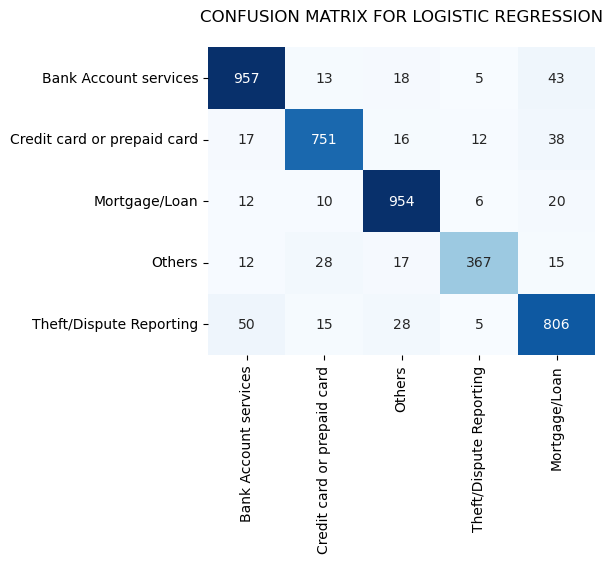

In [57]:
eval_model(y_test,predicted_lr,model_name_1)

## 2. Decision Tree Classifier

In [58]:
# Decision Tree Classifie
model_name_2="DECISION TREE CLASSIFIER"
decision_tree=DecisionTreeClassifier().fit(X_train,y_train)
predicted_dtc=decision_tree.predict(X_test)

CLASSIFICATION REPORT FOR DECISION TREE CLASSIFIER
 
                             precision    recall  f1-score   support

              Bank Services       0.78      0.77      0.78      1036
Credit card or prepaid card       0.74      0.78      0.76       834
                     Others       0.83      0.83      0.83      1002
    Theft/Dispute Reporting       0.73      0.70      0.71       439
              Mortgage/Loan       0.67      0.65      0.66       904

                   accuracy                           0.75      4215
                  macro avg       0.75      0.75      0.75      4215
               weighted avg       0.75      0.75      0.75      4215



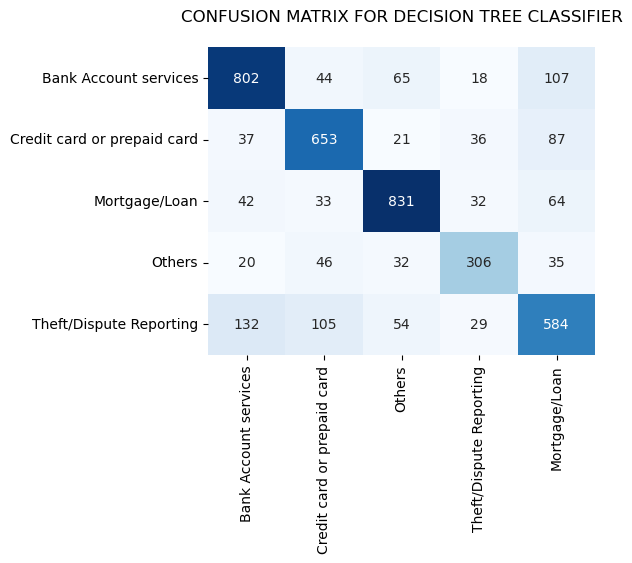

In [59]:
eval_model(y_test,predicted_dtc,model_name_2)

## 3. Random Forest Classifier

In [60]:
# Random Forest Classifier
model_name_3="RANDOM FOREST CLASSIFIER"
random_forest=RandomForestClassifier().fit(X_train,y_train)
predicted_rfc=random_forest.predict(X_test)

CLASSIFICATION REPORT FOR RANDOM FOREST CLASSIFIER
 
                             precision    recall  f1-score   support

              Bank Services       0.78      0.90      0.83      1036
Credit card or prepaid card       0.79      0.78      0.79       834
                     Others       0.85      0.90      0.87      1002
    Theft/Dispute Reporting       0.91      0.68      0.78       439
              Mortgage/Loan       0.80      0.71      0.75       904

                   accuracy                           0.81      4215
                  macro avg       0.83      0.80      0.81      4215
               weighted avg       0.82      0.81      0.81      4215



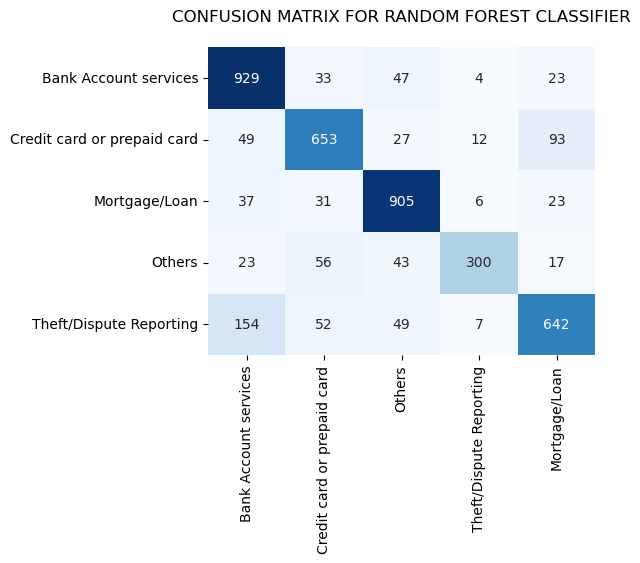

In [61]:
eval_model(y_test,predicted_rfc,model_name_3)

## 4. NAIVE BAYES

In [62]:
# Multinomial Naive Bayes

model_name_4="NAIVE BAYES CLASSIFIER"
naive_bayes= MultinomialNB().fit(X_train,y_train)
predicted_nb=naive_bayes.predict(X_test)

CLASSIFICATION REPORT FOR NAIVE BAYES CLASSIFIER
 
                             precision    recall  f1-score   support

              Bank Services       0.78      0.90      0.83      1036
Credit card or prepaid card       0.79      0.78      0.79       834
                     Others       0.85      0.90      0.87      1002
    Theft/Dispute Reporting       0.91      0.68      0.78       439
              Mortgage/Loan       0.80      0.71      0.75       904

                   accuracy                           0.81      4215
                  macro avg       0.83      0.80      0.81      4215
               weighted avg       0.82      0.81      0.81      4215



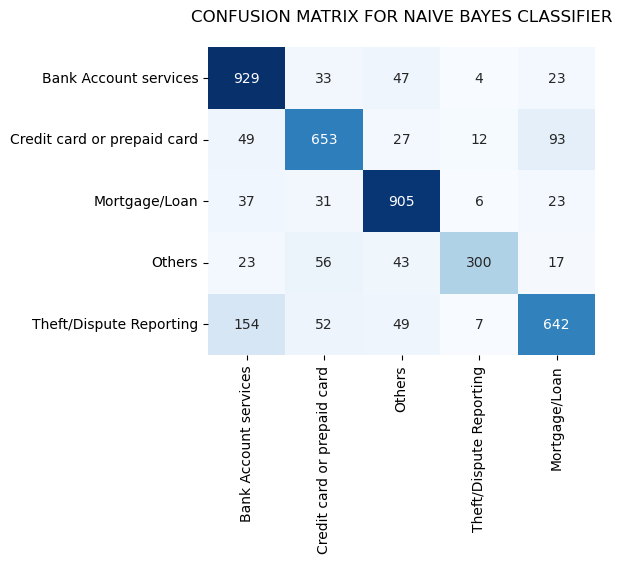

In [63]:
eval_model(y_test,predicted_rfc,model_name_4)

## Training Summary

| Model               | Precision | Recall | F Value | Accuracy | Remarks         |
|---------------------|-----------|--------|---------|----------|-----------------|
| Logistic Regression |  0.91     | 0.91   |  0.91   | 0.91     | Baseline Model  |
| Decision Tree       |  0.75     | 0.75   |  0.75   | 0.75     | Baseline Model  |
| Random Forest       |  0.82     | 0.81   |   0.81  | 0.81     | Baseline Model  |
| Naive Bayes         |  0.82     | 0.82   |   0.81  | 0.82     | Baseline Model  |


Based on the above result, we can see that the **Logistic Regression** model gives a good balance between Precision and Recall, and also Accuracy Scores are very good

## Model inference

In [64]:
# Lets take some sample complaints

sample_complaints = pd.DataFrame({'Complaints': [
    "I noticed some unauthorized transactions in my bank account. Please help me resolve this issue.",
    "I have a question about a recent transaction in my account. Can you provide clarification?",
    "I am experiencing difficulties accessing my credit card account online.",
    "I want to inquire about the process for applying for a home loan from the bank."
]})

sample_complaints

,Complaints
0,I noticed some unauthorized transactions in my bank account. Please help me resolve this issue.
1,I have a question about a recent transaction in my account. Can you provide clarification?
2,I am experiencing difficulties accessing my credit card account online.
3,I want to inquire about the process for applying for a home loan from the bank.


In [65]:
# define a function to predict the topic of above sample examples

def predict_topic(text):
    topic_names={
        0 : "Bank account services",
        1 : "Credit Card/Prepaid Card",
        2 : "Mortgages/loans",
        3 : "Others",
        4 : "Theft/Dispute reporting"
    }
    sample_count=count_vectorizer.transform(text)
    sample_tfidf=tfidf_transformer.transform(sample_count)
    predicted_topic=logistic_regression.predict(sample_tfidf)
    return topic_names[predicted_topic[0]]


In [66]:
sample_complaints['Predicted_Topic']=sample_complaints['Complaints'].apply(lambda x:predict_topic([x]))
sample_complaints

,Complaints,Predicted_Topic
0,I noticed some unauthorized transactions in my bank account. Please help me resolve this issue.,Bank account services
1,I have a question about a recent transaction in my account. Can you provide clarification?,Bank account services
2,I am experiencing difficulties accessing my credit card account online.,Credit Card/Prepaid Card
3,I want to inquire about the process for applying for a home loan from the bank.,Mortgages/loans


## INFERENCE 

As expected, the topics of the sample complaints are predicted correctly using the logistic regression model.